<IPython.core.display.Javascript object>


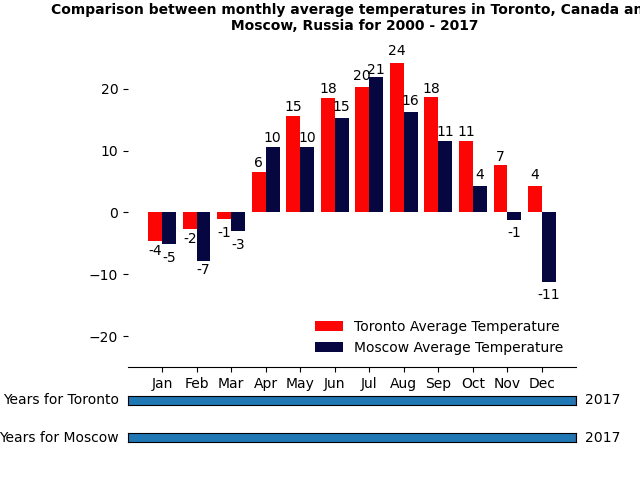

In [22]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
import calendar
from matplotlib.widgets import Slider
%matplotlib notebook


# Getting Data from the sources
Moscow_T = pd.read_csv('RSMOSCOW.txt', header = None, sep = '\s+')
Toronto_T = pd.read_csv('Canadian_climate_history.csv')
#Since there are no Headers, we need to assign them
Moscow_T.columns = ['Month', 'Day', 'Year', 'Temperature']
Moscow_T['Temperature'] = Moscow_T['Temperature'].apply(lambda x: round((x-32)*5/9,2))
#Choose specific columns from Toronto Dataset
Toronto_T = Toronto_T[['LOCAL_DATE','MEAN_TEMPERATURE_TORONTO','TOTAL_PRECIPITATION_TORONTO']]

#Clearing up DateTime data for Toronto and Moscow Datasets. We split them first, then convert month names, and then convert
#to DateTime format. Not most efficient way: i learned that i could have been done quicker while working on this project
Toronto_T[['Day', 'Month', 'Year']] = Toronto_T['LOCAL_DATE'].str.split('-', expand = True)
Toronto_T['Year'] = Toronto_T['Year'].str.split(' ').str[0]
#Filtering out all years except 2000 - 2017
Moscow_T = Moscow_T[(Moscow_T['Year'] > 1999) & (Moscow_T['Year'] < 2018)]
Toronto_T  = Toronto_T[(Toronto_T['Year'] > '1999') & (Toronto_T['LOCAL_DATE'] < '2018')]


dates_dicts = {'Dec': 'December', 'Jan': 'January', 'Feb': 'February', 'Mar':'March', 'Apr': 'April', 'May': 'May',
               'Jun': 'June', 'Jul': 'July', 'Aug':'August', 'Sep': 'September', 'Oct': 'October', 'Nov':'November'}
Toronto_T['Month'] = Toronto_T['Month'].apply(lambda x: dates_dicts[x])
Toronto_T['Month'] = pd.to_datetime(Toronto_T['Month'], format = '%B')
Moscow_T['Month'] = Moscow_T['Month'].apply(lambda x: dates_dicts[calendar.month_abbr[x]])
Moscow_T['Month'] = pd.to_datetime(Moscow_T['Month'], format = '%B')
Toronto_T['Year'] = pd.to_numeric(Toronto_T['Year'])

#Making space for our main plot and sliders
spec1 = gridspec.GridSpec(12,30, hspace = 3)
plt1 = plt.subplot(spec1[0:9,:])
plt2 = plt.subplot(spec1[9:10, :])
plt3 = plt.subplot(spec1[10:11, :])
plt.subplots_adjust(left=0.2, bottom=0)



#Initializing two graphs:
bar1 = plt1.bar(x - 0.2, Toronto_T.loc[Toronto_T['Year']==2001, :].groupby(['Year', 'Month']).MEAN_TEMPERATURE_TORONTO.agg('mean').to_list(), 0.4, color = '#fc0505', label  = 'Toronto Average Temperature')
bar2 = plt1.bar(x + 0.2, Moscow_T.loc[Moscow_T['Year']==2001, :].groupby(['Year', 'Month']).Temperature.agg('mean').to_list(), 0.4, color = '#060740', label = 'Moscow Average Temperature')

# General Fomrating of our plot area
labels = Toronto_T.loc[Toronto_T['Year'] == '2001', 'Month'].unique()
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec']
x = np.arange(len(labels))
plt1.set_xticks(x)
plt1.set_xticklabels(labels)
plt1.set_ylim(-25, 25)
plt1.spines['right'].set_visible(False)
plt1.spines['top'].set_visible(False)
plt1.spines['left'].set_visible(False)
plt1.legend(loc = 4,  frameon = False)
plt1.set_title('Comparison between monthly average temperatures in Toronto, Canada and\n Moscow, Russia for 2000 - 2017', fontsize = 10, fontweight = 'bold', pad = 20)



#Initializing Sliders for each city
slider1 = Slider(plt2, 'Years for Toronto', 2000, 2017, valinit=2017, valstep=1, valfmt='%0.0f')
slider2 = Slider(plt3, 'Years for Moscow', 2000, 2017, valinit=2017, valstep=1, valfmt='%0.0f')
newval = Moscow_T.loc[Moscow_T['Year']==2002, :].groupby(['Year', 'Month']).Temperature.agg('mean').to_list()
  
ann_list1 = []
ann_list2 = []

# Implementing a class which will take care of updating bar charts based on user's actions

class Update(object):

    #Update BarChart for Moscow every time user moves slider2
    def update_val2(self, event):
        self.x = slider2.val
        self.newval = Moscow_T.loc[Moscow_T['Year']==self.x, :].groupby(['Year', 'Month']).Temperature.agg('mean').to_list()
        for rect, val in zip(bar2, self.newval):
            rect.set_height(val)
        self.update_label2(bar2)
        fig.canvas.draw_idle()
    #Update BarChart for Toronto every time user moves slider1
    def update_val1(self, event):
        self.y = slider1.val
        self.newval2 = Toronto_T.loc[Toronto_T['Year']==self.y, :].groupby(['Year', 'Month']).MEAN_TEMPERATURE_TORONTO.agg('mean').to_list()
        for rect2, val2 in zip(bar1, self.newval2):
            rect2.set_height(val2)
        self.update_label1(bar1)
        fig.canvas.draw_idle()
        
    #Funciton to update BarChart labels for Moscow  
    def update_label2(self, bar):
        for i, a in enumerate(ann_list1):
            a.remove()
        ann_list1[:] = []
        for rect in bar:
            height = int(rect.get_height())
            if height < 0: pos = -13
            else: pos = 6
            ann1 = plt1.annotate('{}'.format(height),
                          xy=(rect.get_x() + rect.get_width() / 2, height),
                          xytext=(0, pos),
                          textcoords="offset points",
                          ha='center')
            ann_list1.append(ann1)
    
    #Funciton to update BarChart labels for Toronto
    def update_label1(self, bar):
        for i, a in enumerate(ann_list2):
            a.remove()
        ann_list2[:] = []
        for rect in bar:
            height = int(rect.get_height())
            if height < 0: pos = -13
            else: pos = 6
            ann2 = plt1.annotate('{}'.format(height),
                          xy=(rect.get_x() + rect.get_width() / 2, height),
                          xytext=(0, pos),
                          textcoords="offset points",
                          ha='center')
            ann_list2.append(ann2)           
        
# Initialization of an instance of class 'Update' and few line for event receivers.
callback = Update()
slider1.on_changed(callback.update_val1)
slider2.on_changed(callback.update_val2)
callback.update_label1(bar1)
callback.update_label2(bar2)


plt.show()

In [102]:

#Toronto_T.dtypes